# Optimising a parameterised ODE

Here's an example in which we optimise the parameters of an ODE. This means we have a differential equation solve inside our nonlinear solve!

First, import everything. Regarding the libraries we're using: [Diffrax](https://github.com/patrick-kidger/diffrax) for differential equation solving, [jaxtyping](https://github.com/google/jaxtyping) for type annotations, and [Equinox](https://github.com/patrick-kidger/equinox) for some "smarter" JAX operations. (Equinox is used as the foundation of all of Optimistix/Diffrax/etc.)

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import diffrax as dfx  # https://github.com/patrick-kidger/diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import optimistix as optx
from jaxtyping import Array, Float  # https://github.com/google/jaxtyping

The problem we'll try and tackle is a relatively simple one: fitting the [Lotka--Volterra equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations).

In [2]:
def vector_field(
    t, y: Float[Array, "2"], parameters: Float[Array, "4"]
) -> Float[Array, "2"]:
    prey, predator = y
    α, β, γ, δ = parameters
    d_prey = α * prey - β * prey * predator
    d_predator = -γ * predator + δ * prey * predator
    d_y = jnp.stack([d_prey, d_predator])
    return d_y


def solve(
    parameters: Float[Array, "4"], y0: Float[Array, "2"], saveat: dfx.SaveAt
) -> Float[Array, "ts"]:
    """Solve a single ODE."""
    term = dfx.ODETerm(vector_field)
    solver = dfx.Tsit5()
    t0 = saveat.subs.ts[0]
    t1 = saveat.subs.ts[-1]
    dt0 = 0.1
    sol = dfx.diffeqsolve(
        term,
        solver,
        t0,
        t1,
        dt0,
        y0,
        args=parameters,
        saveat=saveat,
        # support forward-mode autodiff, which is used by Levenberg--Marquardt
        adjoint=dfx.DirectAdjoint(),
    )
    return sol.ys

Let's quickly simulate some training data. The fact that this is also coming from the Lotka--Volterra equations means that we're hoping to get a perfect fit with the parameters. In practice, on real-world data, that's unlikely to be true!

In [3]:
def get_data() -> tuple[Float[Array, "3 2"], Float[Array, "3 50"]]:
    """Simulate some training data."""
    # We consider three possible initial conditions.
    y0_a = jnp.array([9.0, 9.0])
    y0_b = jnp.array([10.0, 10.0])
    y0_c = jnp.array([11.0, 11.0])
    y0s = jnp.stack([y0_a, y0_b, y0_c])
    true_parameters = jnp.array([0.1, 0.02, 0.4, 0.02])
    saveat = dfx.SaveAt(ts=jnp.linspace(0, 30, 20))
    batch_solve = eqx.filter_jit(eqx.filter_vmap(solve, in_axes=(None, 0, None)))
    values = batch_solve(true_parameters, y0s, saveat)
    return y0s, values

And now let's run our solver.
Some solvers support a `verbose` option, to get a printout of how the optimisation proceeds. We turn that on in this case.

In [4]:
def residuals(parameters, y0s__values):
    y0s, values = y0s__values
    saveat = dfx.SaveAt(ts=jnp.linspace(0, 30, 20))
    batch_solve = eqx.filter_vmap(solve, in_axes=(None, 0, None))
    pred_values = batch_solve(parameters, y0s, saveat)
    return values - pred_values


(y0s, values) = get_data()
solver = optx.LevenbergMarquardt(
    rtol=1e-8, atol=1e-8, verbose=frozenset({"step", "accepted", "loss", "step_size"})
)

init_parameters = jnp.zeros(4)
sol = optx.least_squares(residuals, solver, init_parameters, args=(y0s, values))

Step: 0 , Accepted steps: 0 , Steps since acceptance: 0 , Loss on this step: 8342.5693359375 , Loss on the last accepted step: 0.0 , Step size: 1.0
Step: 1 , Accepted steps: 1 , Steps since acceptance: 0 , Loss on this step: 8628328.0 , Loss on the last accepted step: 8342.5693359375 , Step size: 0.25
Step: 2 , Accepted steps: 1 , Steps since acceptance: 1 , Loss on this step: 8608194.0 , Loss on the last accepted step: 8342.5693359375 , Step size: 0.0625
Step: 3 , Accepted steps: 1 , Steps since acceptance: 2 , Loss on this step: 8528131.0 , Loss on the last accepted step: 8342.5693359375 , Step size: 0.015625
Step: 4 , Accepted steps: 1 , Steps since acceptance: 3 , Loss on this step: 8217127.5 , Loss on the last accepted step: 8342.5693359375 , Step size: 0.00390625
Step: 5 , Accepted steps: 1 , Steps since acceptance: 4 , Loss on this step: 7105586.5 , Loss on the last accepted step: 8342.5693359375 , Step size: 0.0009765625
Step: 6 , Accepted steps: 1 , Steps since acceptance: 5 ,

Alright, we're getting told that the loss is about zero. Let's check that:

In [5]:
optx.max_norm(residuals(sol.value, (y0s, values)))

Array(1.9073486e-05, dtype=float32)

That looks pretty good! Let's see what the solution looks like:

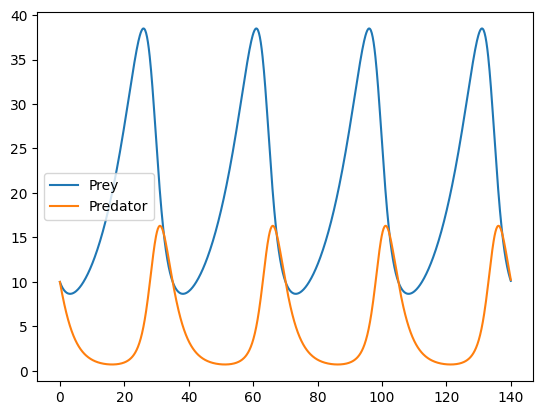

In [6]:
ts = jnp.linspace(0, 140, 1000)
ys = solve(sol.value, jnp.array([10.0, 10.0]), dfx.SaveAt(ts=ts))
plt.plot(ts, ys[:, 0], label="Prey")
plt.plot(ts, ys[:, 1], label="Predator")
plt.legend()
plt.show()

!!! tip

    Here are two tips for fitting ODEs like this.

    First, we started with an initial guess of all of our parameters being zero. This corresponds to the vector field of the ODE being zero, **which means that the initial solution of the ODE is constant**. In contrast if we'd set some other values for the initial parameters, then our ODE might evolve to produce trajectories that are very far away from our data.

    Second: we fit to quite a short time series (20 points over the interval [0, 30]; note that we produced our final plot over a much longer time interval). It's quite common for optimisation to get stuck in a bad local minima if you try to fit to a long time series straight away. It's much better to gradually lengthen the time series you try to fit.